In [1]:
import sys

DATA_PATH = '../../IFT6758_Data/'
PROJECT_PATH = '../../Milestone2/'


sys.path.append(PROJECT_PATH)

In [2]:
from comet_ml import Experiment
import numpy as np
import pandas as pd
import seaborn as sns
import optuna
import shap
import pickle
import matplotlib.pyplot as plt
import sklearn
import imblearn
from sklearn import metrics
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.calibration import calibration_curve, CalibrationDisplay
from sklearn.svm import LinearSVC
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import VarianceThreshold, SelectKBest, mutual_info_classif, SelectFromModel
import os
import xgboost as xgb

from visualizations.simple_visualization import *
from models.generate_plots import *
from features.feature_eng1 import *

In [3]:
X = pd.read_csv(DATA_PATH + '/clean_train_data.csv', index_col=0)

In [4]:
has_nan = X.isna().any().any()

if has_nan:
    print("There are NaN values in the DataFrame 'X'.")
    # Dropping NaNs since these events do not have x and y coordinates
    X.dropna(inplace=True)
    X = X.reset_index(drop=True)
else:
    print("There are no NaN values in the DataFrame 'X'.")

X = X[~X.isin([np.nan, np.inf, -np.inf]).any(1)]
X = X.reset_index(drop=True)

There are NaN values in the DataFrame 'X'.


In [5]:
X, y = X.iloc[:, :-1], X.iloc[:, -1]
y.value_counts(normalize=True).round(2)*100

0    91.0
1     9.0
Name: is_goal, dtype: float64

In [6]:
num_cols = X.select_dtypes([np.number]).columns
scaler = StandardScaler()
X[num_cols] = scaler.fit_transform(X[num_cols])

categorical_cols = X.select_dtypes(exclude=["number", "bool_"]).columns
X = pd.get_dummies(data=X, columns=categorical_cols)

boolean_cols = X.select_dtypes([bool]).columns
X[boolean_cols] = X[boolean_cols].astype(int)
X = X.reset_index(drop=True)

In [7]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

In [8]:
smo_tek = imblearn.combine.SMOTETomek(random_state=42)
X_smotek, y_smotek = smo_tek.fit_resample(X_train, y_train)

In [9]:
params = {'objective':'binary:logistic',
 'booster': 'gbtree',
 'lambda': 0.33121383940964394,
 'alpha': 7.269895266157583e-05,
 'max_depth': 9,
 'eta': 0.0965393557819441,
 'gamma': 3.264214468562427e-06,
 'grow_policy': 'depthwise'}

model = xgb.XGBClassifier(**params)

model.fit(X_smotek, y_smotek)

XGBClassifier(alpha=7.269895266157583e-05, base_score=0.5, booster='gbtree',
              callbacks=None, colsample_bylevel=1, colsample_bynode=1,
              colsample_bytree=1, early_stopping_rounds=None,
              enable_categorical=False, eta=0.0965393557819441,
              eval_metric=None, gamma=3.264214468562427e-06, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', lambda=0.33121383940964394,
              learning_rate=0.0965393558, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=9, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', ...)

In [10]:
y_pred = model.predict(X_val)
accuracy = metrics.accuracy_score(y_val, y_pred)
print(f'Accuracy score is {accuracy}')

Accuracy score is 0.881604443870301


In [11]:
smotek_f1 = metrics.f1_score(y_val, y_pred)
smotek_accuracy = metrics.accuracy_score(y_val, y_pred)
smotek_precision = metrics.precision_score(y_val, y_pred)
smotek_recall = metrics.recall_score(y_val, y_pred)

In [ ]:
pickle.dump(model, open("SMOTek_xgb_model.pkl", "wb"))

In [ ]:
experiment = Experiment(
  api_key='lqXuPyhuPClaazZKtvHZe5jFS',
  project_name="nhl-project-b10",
  workspace="ift6758b-project-b10"
)

In [ ]:
evaluation = {"accuracy": smotek_accuracy, "f1": smotek_f1, "recall": smotek_recall, "precision": smotek_precision}
params = {
    "model": 'XGBoost with SMOTek',
    "description": 'XGBoost Classifier with SMOTek',
    **model.get_params()
}

In [ ]:
experiment.set_name('XGBoost with SMOTek')
experiment.log_parameters(params)
experiment.log_metrics(evaluation)

experiment.log_model('6-1 XGBoost Classifier with SMOTek', 'SMOTek_xgb_model.pkl')

In [ ]:
experiment.end()

In [12]:
y_pred_prob = model.predict_proba(X_val)[:, 1]
df_percentile =  calc_percentile(y_pred_prob, y_val)

goal_rate_df = goal_rate(df_percentile)

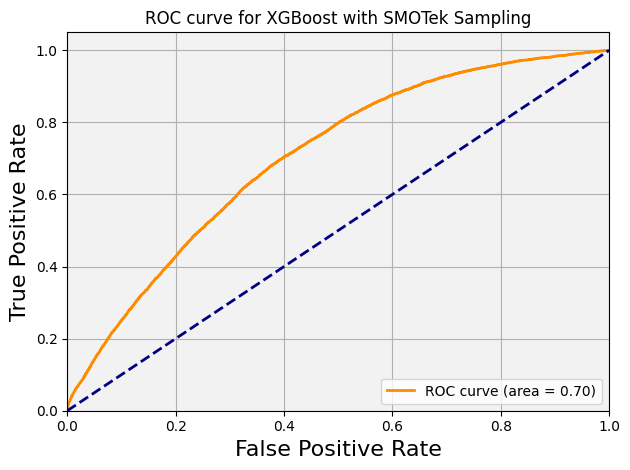

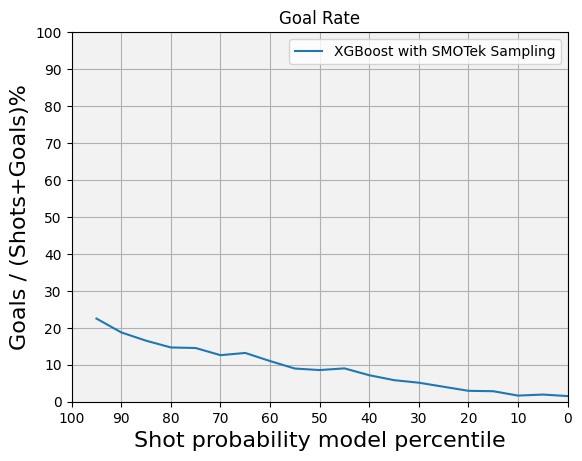

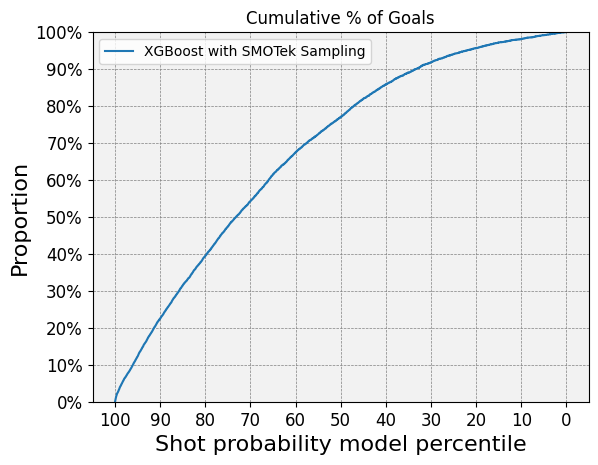

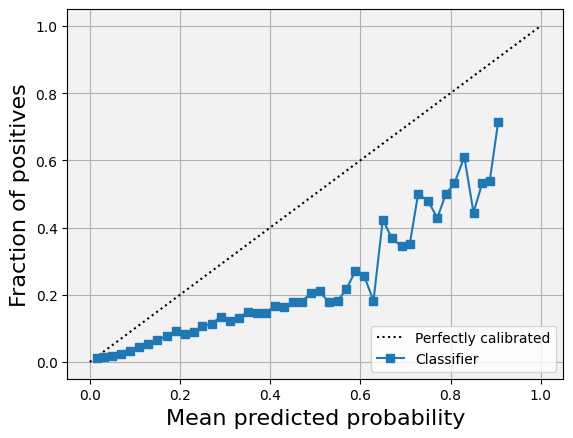

In [13]:
plot_ROC(y_val, y_pred_prob, 'ROC curve for XGBoost with SMOTek Sampling', '6-1a ROC Curve')
plot_goal_rates(goal_rate_df, 'XGBoost with SMOTek Sampling', '6-1b Goal Rate')
plot_cumulative_goal_rates(df_percentile, 'XGBoost with SMOTek Sampling', '6-1c Cumulative Goal Percentage')
plot_calibration_curve_prediction(y_val, y_pred_prob, '6-1d Calibration Plot')